In [1]:
from google.colab import files
files.upload()  # Select kaggle.json from your system


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prachetpandav","key":"d0a940019c21a30c427852dbb2fd13d7"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d requiemonk/sentinel12-image-pairs-segregated-by-terrain

Dataset URL: https://www.kaggle.com/datasets/requiemonk/sentinel12-image-pairs-segregated-by-terrain
License(s): Attribution 4.0 International (CC BY 4.0)


In [4]:
import zipfile

dataset_zip = "/content/sentinel12-image-pairs-segregated-by-terrain.zip"  # Change this to the actual file name
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("sentinel_sar_dataset")

# Check extracted files
import os
print(os.listdir("sentinel_sar_dataset"))

['v_2']


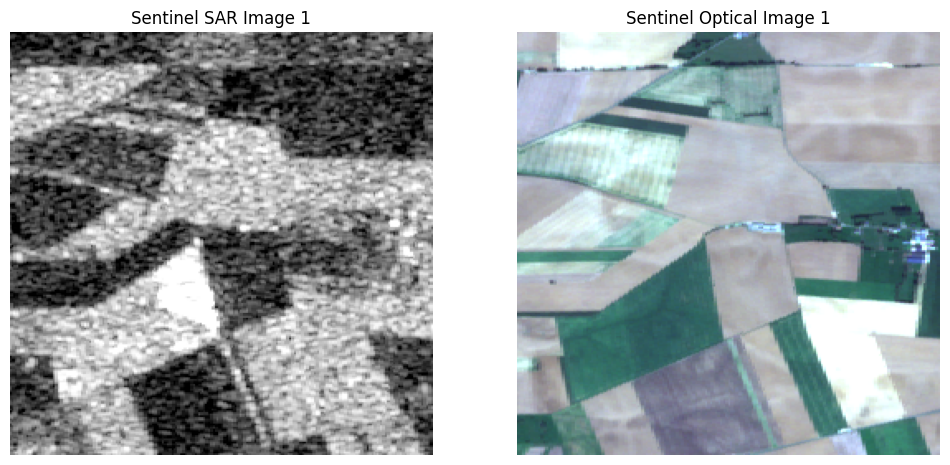

In [5]:
import matplotlib.pyplot as plt
import cv2

# Define paths for both images
image_path_1 = "/content/sentinel_sar_dataset/v_2/agri/s1/ROIs1868_summer_s1_59_p10.png"
image_path_2 = "/content/sentinel_sar_dataset/v_2/agri/s2/ROIs1868_summer_s2_59_p10.png"

# Load images in original color format (BGR to RGB)
image1 = cv2.imread(image_path_1)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

image2 = cv2.imread(image_path_2)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display both images side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title("Sentinel SAR Image 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title("Sentinel Optical Image 1")
plt.axis("off")

plt.show()

# Pix2Pix

In [14]:
import os
import cv2
import shutil
import random

# Define dataset paths
dataset_root = "/content/sentinel_sar_dataset/v_2"
output_root = "/content/preprocessed_data"
terrain = "urban"  # Only Urban

# Create required directories
os.makedirs(f"{output_root}/train/A", exist_ok=True)
os.makedirs(f"{output_root}/train/B", exist_ok=True)

# Select 400 SAR images
num_images = 400
sar_images = sorted(os.listdir(f"{dataset_root}/{terrain}/s1"))[:num_images]

for img in sar_images:
    if img.startswith("ROIs") and "_s1_" in img:
        optical_img = img.replace("_s1_", "_s2_")  # Correctly match SAR to Optical

        sar_path = os.path.join(dataset_root, terrain, "s1", img)
        optical_path = os.path.join(dataset_root, terrain, "s2", optical_img)

        if os.path.exists(optical_path):  # Ensure both images exist before copying
            shutil.copy(sar_path, f"{output_root}/train/A/{img}")
            shutil.copy(optical_path, f"{output_root}/train/B/{optical_img}")

# Resize images to 256x256
def resize_images(folder):
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (256, 256))
            cv2.imwrite(img_path, img)

resize_images(f"{output_root}/train/A")
resize_images(f"{output_root}/train/B")

print(f"✅ Dataset is ready! {len(os.listdir(output_root+'/train/A'))} image pairs saved.")


✅ Dataset is ready! 400 image pairs saved.


In [8]:
!pip install tensorflow tensorflow-datasets matplotlib
!pip install git+https://github.com/tensorflow/examples.git


  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-13tiqkmj
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-13tiqkmj
  Resolved https://github.com/tensorflow/examples.git to commit fed63294c10c71b7da028e0e75de9ff68ac56d17
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1741282361.1454860421494433302046033067432040489300359736599-py3-none-any.whl size=301643 sha256=cbabb41dd005ae937e1b27b14d5ebca67a8f15d866be4cca3e4b61c9ff612542
  Stored in directory: /tmp/pip-ephem-wheel-cache-rf8psni3/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import time
import matplotlib.pyplot as plt

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output


In [15]:
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load images
def load_image(image_path):
    img = load_img(image_path, target_size=(256, 256))  # Resize if needed
    img = img_to_array(img) / 127.5 - 1  # Normalize to [-1,1]
    return img

# Get image paths
sar_images = sorted(glob.glob("/content/preprocessed_data/train/A/*.png"))
optical_images = sorted(glob.glob("/content/preprocessed_data/train/B/*.png"))

# Create dataset
X_train = np.array([load_image(img) for img in sar_images])
Y_train = np.array([load_image(img) for img in optical_images])

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(16)

print(f"✅ Loaded {len(X_train)} training pairs!")


✅ Loaded 400 training pairs!


In [16]:
OUTPUT_CHANNELS = 3  # RGB Output

# Generator
generator = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='batchnorm')
generator.summary()

# Discriminator
discriminator = pix2pix.discriminator(norm_type='batchnorm', target=True)
discriminator.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None,      │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, None,      │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, None,      │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, None,      │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, None,      │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, None,      │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, None,      │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, None,      │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, None,      │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ None, 128)        │            │ sequential_6[0][… │
│                     │                   │            │ sequential_9[0][… │
│                     │                   │            │ sequential_5[0][… │
│                     │                   │            │ sequential_10[0]… │
│                     │                   │            │ sequential_4[0][… │
│                     │                   │            │ sequential_11[0]… │
│                     │                   │            │ sequential_3[0][… │
│                     │                   │            │ sequential_12[0]… │
│                     │                   │            │ sequential_2[0][… │
│                     │                   │            │ sequential_13[0]… │
│                     │                   │            │ sequential_1[0][… │
│                     │                   │            │ sequential_14[0]… │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, None,      │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, None,      │  8,390,656 │ concatenate[1][0

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None,      │          0 │ input_image[0][0… │
│ (Concatenate)       │ None, 6)          │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, None,      │      6,144 │ concatenate_1[0]… │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, None,      │    131,584 │ sequential_15[0]… │
│ (Sequential)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, None,      │    525,312 │ sequential_16[0]… │
│ (Sequential)        │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ sequential_17[0]… │
│ (ZeroPadding2D)     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, None,      │  2,097,152 │ zero_padding2d[0… │
│                     │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │      2,048 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, None,      │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ leaky_re_lu_11[0… │
│ (ZeroPadding2D)     │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, None,      │      8,193 │ zero_padding2d_1… │
│                     │ None, 1)          │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [17]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_loss = gan_loss + (100 * l1_loss)
    return total_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [18]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [19]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [24]:
EPOCHS = 25  # Increase for better results

for epoch in range(EPOCHS):
    start = time.time()

    for input_image, target in train_dataset:
        gen_loss, disc_loss = train_step(input_image, target)

    clear_output(wait=True)
    print(f"Epoch {epoch+1}/{EPOCHS} - Gen Loss: {gen_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}")
    print(f"Time for epoch {epoch+1} is {time.time()-start:.2f} sec\n")


Epoch 25/25 - Gen Loss: 16.6213, Disc Loss: 0.8978
Time for epoch 25 is 14.89 sec



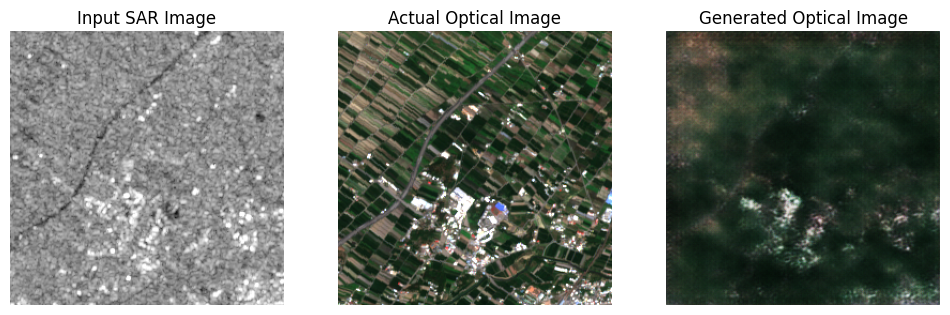

In [25]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow((test_input[0] + 1) / 2)
    plt.title("Input SAR Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow((tar[0] + 1) / 2)
    plt.title("Actual Optical Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow((prediction[0] + 1) / 2)
    plt.title("Generated Optical Image")
    plt.axis("off")

    plt.show()

# Test on a sample image
sample_input = X_train[:1]
sample_target = Y_train[:1]
generate_images(generator, sample_input, sample_target)


In [26]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(original, generated):
    """Compute SSIM between the original and generated images."""
    original_gray = tf.image.rgb_to_grayscale(original)
    generated_gray = tf.image.rgb_to_grayscale(generated)

    ssim_score = ssim(original_gray.numpy().squeeze(), generated_gray.numpy().squeeze(), data_range=2)
    return ssim_score

# Evaluate on test images
ssim_scores = []
for i in range(len(X_train[:10])):  # Evaluate on 10 samples
    original = Y_train[i:i+1]  # Ground truth
    generated = generator(X_train[i:i+1], training=False)  # Generated image

    ssim_scores.append(calculate_ssim(original, generated))

print(f"📊 Average SSIM: {np.mean(ssim_scores):.4f}")


📊 Average SSIM: 0.1793


In [27]:
import tensorflow as tf

def calculate_psnr(original, generated):
    """Compute PSNR between original and generated images."""
    psnr_score = tf.image.psnr(original, generated, max_val=2.0)
    return psnr_score.numpy()

# Evaluate on test images
psnr_scores = []
for i in range(len(X_train[:10])):
    original = Y_train[i:i+1]  # Ground truth
    generated = generator(X_train[i:i+1], training=False)  # Generated image

    psnr_scores.append(calculate_psnr(original, generated))

print(f"📊 Average PSNR: {np.mean(psnr_scores):.4f} dB")


📊 Average PSNR: 13.3499 dB


#UNet

In [28]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Paths
dataset_root = "/content/sentinel_sar_dataset/v_2/urban"
image_size = (256, 256)
num_images = 400  # Training with 400 images

# Load images
def load_images(folder, num_images):
    image_files = sorted(os.listdir(folder))[:num_images]
    images = [img_to_array(load_img(os.path.join(folder, img), target_size=image_size)) for img in image_files]
    return np.array(images) / 255.0  # Normalize

# Load SAR (input) and Optical (target)
X_train = load_images(f"{dataset_root}/s1", num_images)
Y_train = load_images(f"{dataset_root}/s2", num_images)

print(f"✅ Loaded {X_train.shape[0]} SAR images & {Y_train.shape[0]} Optical images.")


✅ Loaded 400 SAR images & 400 Optical images.


In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

def unet_model(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Encoder (Downsampling)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder (Upsampling)
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c7)  # Output in range [0,1]

    return Model(inputs, outputs)

# Initialize model
model = unet_model()
model.summary()


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_19[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_13[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_15[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_17[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_19[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 64, 64,    │    524,544 │ conv2d_20[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │  1,179,904 │ concatenate_2[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_21[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 128, 128,  │    131,200 │ conv2d_22[0][0] 

 Total params: 7,697,475 (29.36 MB)

 Trainable params: 7,697,475 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train model
history = model.fit(X_train, Y_train, batch_size=16, epochs=25, validation_split=0.1)


Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 880ms/step - loss: 0.0579 - mae: 0.1860 - val_loss: 0.0448 - val_mae: 0.1700
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 617ms/step - loss: 0.0453 - mae: 0.1633 - val_loss: 0.0456 - val_mae: 0.1733
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 627ms/step - loss: 0.0443 - mae: 0.1628 - val_loss: 0.0387 - val_mae: 0.1493
Epoch 4/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 630ms/step - loss: 0.0433 - mae: 0.1586 - val_loss: 0.0441 - val_mae: 0.1696
Epoch 5/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 622ms/step - loss: 0.0423 - mae: 0.1580 - val_loss: 0.0389 - val_mae: 0.1534
Epoch 6/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 625ms/step - loss: 0.0407 - mae: 0.1543 - val_loss: 0.0357 - val_mae: 0.1401
Epoch 7/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 628ms/step - loss: 0.0410 - mae: 0.1526 - val_loss: 0.0456 - val_mae: 0.1747
Epoch 8/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 624ms/step - loss: 0.0407 - mae: 0.1556 - val_loss: 0.0402 - val_mae: 0.1577
Epoch 9/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 626ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


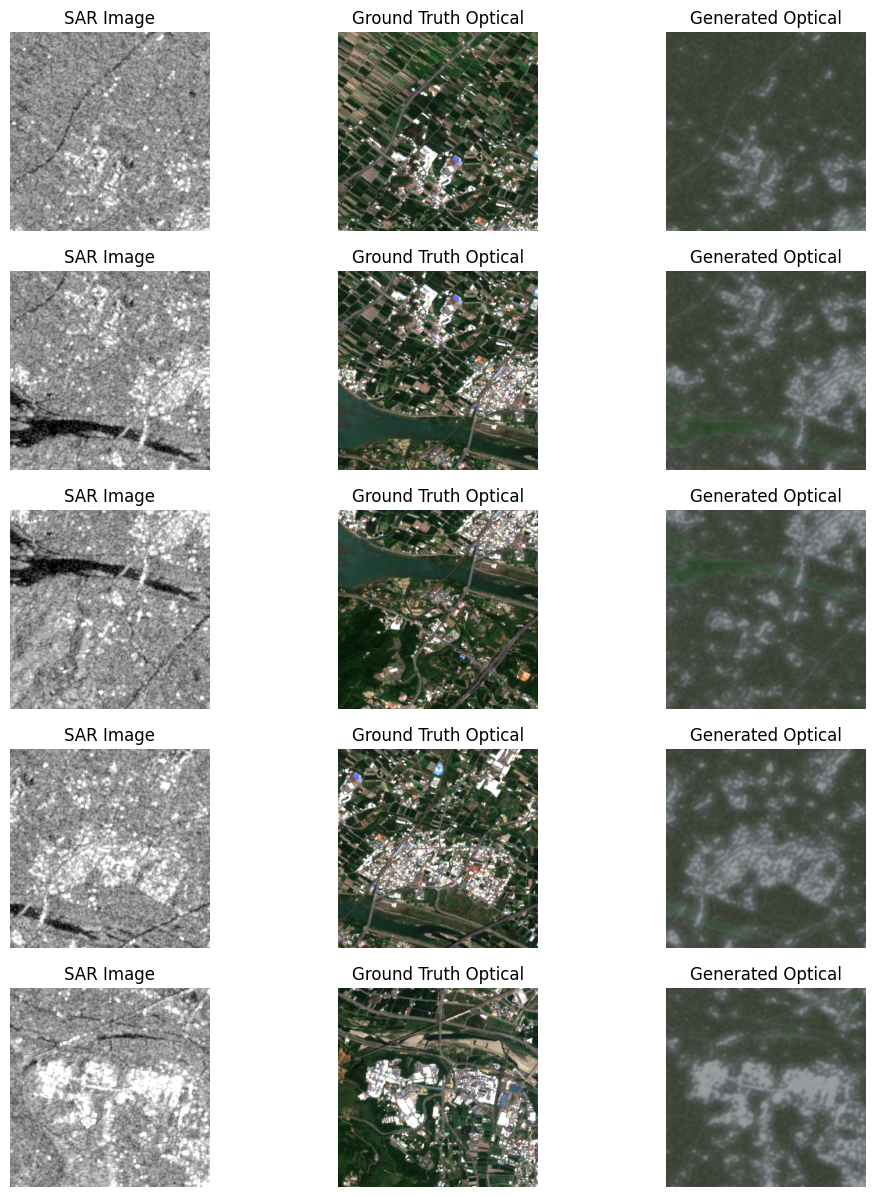

In [38]:
import matplotlib.pyplot as plt

# Predict on test images
predicted_images = model.predict(X_train[:5])  # Testing on first 5 images

# Display results
fig, axes = plt.subplots(5, 3, figsize=(12, 15))

for i in range(5):
    axes[i, 0].imshow(X_train[i])  # Input SAR
    axes[i, 1].imshow(Y_train[i])  # Ground Truth Optical
    axes[i, 2].imshow(predicted_images[i])  # Generated Optical

    axes[i, 0].set_title("SAR Image")
    axes[i, 1].set_title("Ground Truth Optical")
    axes[i, 2].set_title("Generated Optical")

    for ax in axes[i]:
        ax.axis("off")

plt.show()


In [39]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import tensorflow as tf

# Compute SSIM
def calculate_ssim(original, generated):
    original_gray = tf.image.rgb_to_grayscale(original)
    generated_gray = tf.image.rgb_to_grayscale(generated)
    return ssim(original_gray.numpy().squeeze(), generated_gray.numpy().squeeze(), data_range=2)

ssim_scores = [calculate_ssim(Y_train[i], predicted_images[i]) for i in range(5)]
print(f"📊 Average SSIM: {np.mean(ssim_scores):.4f}")

# Compute PSNR
def calculate_psnr(original, generated):
    return tf.image.psnr(original, generated, max_val=1.0).numpy()

psnr_scores = [calculate_psnr(Y_train[i], predicted_images[i]) for i in range(5)]
print(f"📊 Average PSNR: {np.mean(psnr_scores):.4f} dB")

# Compute MAE
def calculate_mae(original, generated):
    return np.mean(np.abs(original - generated))

mae_scores = [calculate_mae(Y_train[i], predicted_images[i]) for i in range(5)]
print(f"📊 Average MAE: {np.mean(mae_scores):.4f}")


📊 Average SSIM: 0.3506
📊 Average PSNR: 14.8435 dB
📊 Average MAE: 0.1390


In [40]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import tensorflow as tf

# Compute SSIM
def calculate_ssim(original, generated):
    original_gray = tf.image.rgb_to_grayscale(original)
    generated_gray = tf.image.rgb_to_grayscale(generated)
    return ssim(original_gray.numpy().squeeze(), generated_gray.numpy().squeeze(), data_range=2)

ssim_scores = [calculate_ssim(Y_train[i], predicted_images[i]) for i in range(5)]
print(f"📊 Average SSIM: {np.mean(ssim_scores):.4f}")

# Compute PSNR
def calculate_psnr(original, generated):
    return tf.image.psnr(original, generated, max_val=1.0).numpy()

psnr_scores = [calculate_psnr(Y_train[i], predicted_images[i]) for i in range(5)]
print(f"📊 Average PSNR: {np.mean(psnr_scores):.4f} dB")

# Compute MAE
def calculate_mae(original, generated):
    return np.mean(np.abs(original - generated))

mae_scores = [calculate_mae(Y_train[i], predicted_images[i]) for i in range(5)]
print(f"📊 Average MAE: {np.mean(mae_scores):.4f}")


📊 Average SSIM: 0.3506
📊 Average PSNR: 14.8435 dB
📊 Average MAE: 0.1390


#UNet 2.0

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import tensorflow.keras.backend as K

# Load VGG16 once and use it in the loss function
vgg = VGG16(include_top=False, weights="imagenet", input_shape=(256, 256, 3))
vgg.trainable = False
perceptual_model = Model(inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output)

def ssim_loss(y_true, y_pred):
    return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)

def perceptual_loss(y_true, y_pred):
    return K.mean(K.abs(perceptual_model(y_true) - perceptual_model(y_pred)))

def combined_loss(y_true, y_pred):
    return 0.5 * ssim_loss(y_true, y_pred) + 0.5 * perceptual_loss(y_true, y_pred)

def unet_model(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c7)

    return Model(inputs, outputs)

# Initialize U-Net Model
model = unet_model()
model.summary()

# Compile Model with New Loss Function
model.compile(optimizer=Adam(learning_rate=0.001), loss=combined_loss, metrics=['mae'])

# Train the Model
history = model.fit(X_train, Y_train, batch_size=16, epochs=25, validation_split=0.1)


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_24[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_43[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 128,  │          0 │ conv2d_44[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_45[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ conv2d_46[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_7[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_47[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 32, 32,    │          0 │ conv2d_48[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_8[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_49[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_14 │ (None, 64, 64,    │    524,544 │ conv2d_50[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_48[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 64, 64,    │  1,179,904 │ concatenate_8[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_51[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_15 │ (None, 128, 128,  │    131,200 │ conv2d_52[0][0] 

 Total params: 7,697,475 (29.36 MB)

 Trainable params: 7,697,475 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.9366 - mae: 0.2479 - val_loss: 1.5189 - val_mae: 0.2353
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 847ms/step - loss: 1.6657 - mae: 0.2155 - val_loss: 1.5307 - val_mae: 0.1918
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 865ms/step - loss: 1.6237 - mae: 0.1780 - val_loss: 1.5633 - val_mae: 0.1708
Epoch 4/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 882ms/step - loss: 1.6150 - mae: 0.1695 - val_loss: 1.5452 - val_mae: 0.1572
Epoch 5/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 880ms/step - loss: 1.5976 - mae: 0.1653 - val_loss: 1.5174 - val_mae: 0.1480
Epoch 6/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 873ms/step - loss: 1.5959 - mae: 0.1598 - val_loss: 1.5085 - val_mae: 0.1542
Epoch 7/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 861ms/step - loss: 1.5923 - mae: 0.1623 - val_loss: 1.4733 - val_mae: 0.1410
Epoch 8/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 871ms/step - loss: 1.5706 - mae: 0.1563 - val_loss: 1.5252 - val_mae: 0.1555
Epoch 9/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 862ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


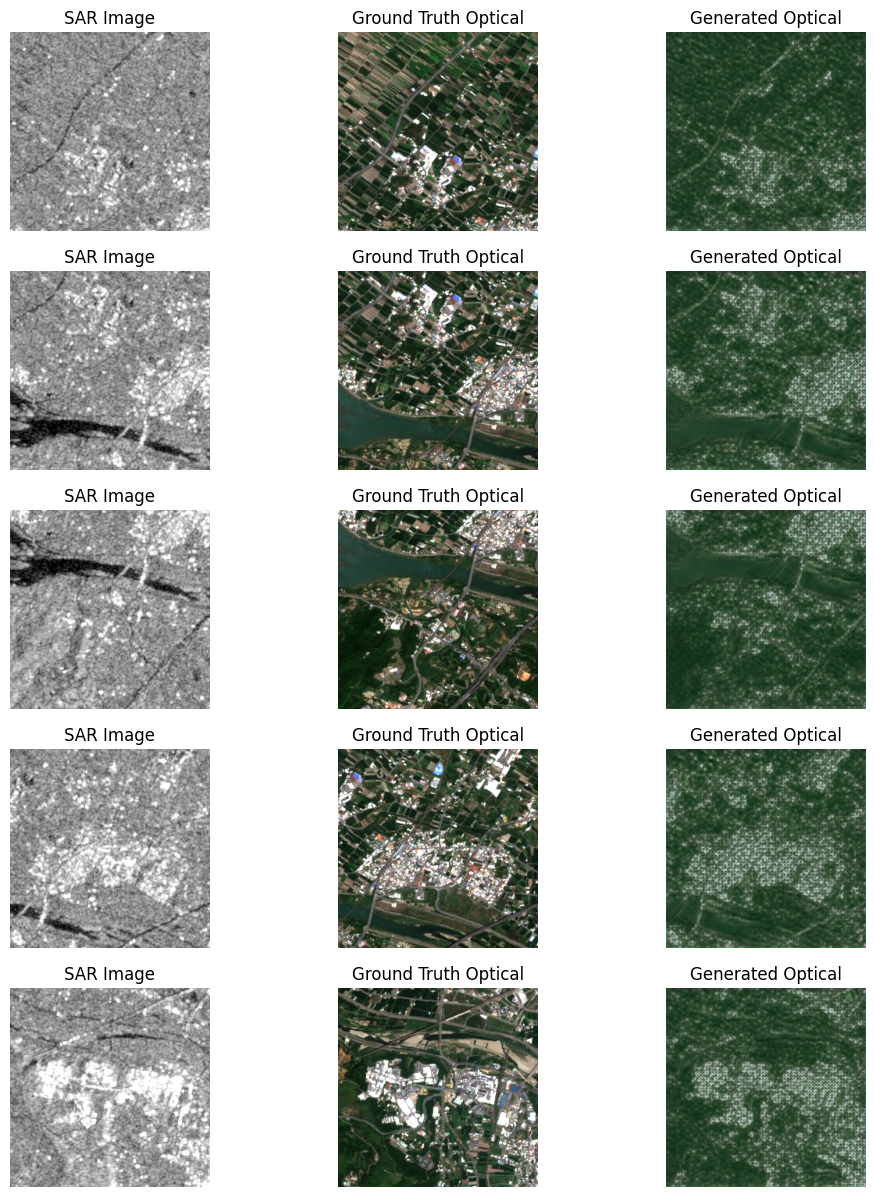

In [43]:
import matplotlib.pyplot as plt

# Predict on test images
predicted_images = model.predict(X_train[:5])  # Testing on first 5 images

# Display results
fig, axes = plt.subplots(5, 3, figsize=(12, 15))

for i in range(5):
    axes[i, 0].imshow(X_train[i])  # Input SAR
    axes[i, 1].imshow(Y_train[i])  # Ground Truth Optical
    axes[i, 2].imshow(predicted_images[i])  # Generated Optical

    axes[i, 0].set_title("SAR Image")
    axes[i, 1].set_title("Ground Truth Optical")
    axes[i, 2].set_title("Generated Optical")

    for ax in axes[i]:
        ax.axis("off")

plt.show()


In [44]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import tensorflow as tf

# Compute SSIM
def calculate_ssim(original, generated):
    original_gray = tf.image.rgb_to_grayscale(original)
    generated_gray = tf.image.rgb_to_grayscale(generated)
    return ssim(original_gray.numpy().squeeze(), generated_gray.numpy().squeeze(), data_range=2)

ssim_scores = [calculate_ssim(Y_train[i], predicted_images[i]) for i in range(5)]
print(f"📊 Average SSIM: {np.mean(ssim_scores):.4f}")

# Compute PSNR
def calculate_psnr(original, generated):
    return tf.image.psnr(original, generated, max_val=1.0).numpy()

psnr_scores = [calculate_psnr(Y_train[i], predicted_images[i]) for i in range(5)]
print(f"📊 Average PSNR: {np.mean(psnr_scores):.4f} dB")

# Compute MAE
def calculate_mae(original, generated):
    return np.mean(np.abs(original - generated))

mae_scores = [calculate_mae(Y_train[i], predicted_images[i]) for i in range(5)]
print(f"📊 Average MAE: {np.mean(mae_scores):.4f}")


📊 Average SSIM: 0.3886
📊 Average PSNR: 14.6864 dB
📊 Average MAE: 0.1287
